# Zajęcie 08: Liniowe RNN - Sumowanie Sekwencji

## Wstęp

Celem zadania jest implementacja liniowej rekurencyjnej sieci neuronowej (Linear RNN) do sumowania sekwencji liczb.

**Architektura RNN:**
$$S_k = S_{k-1} \cdot W_{rec} + X_k \cdot W_x$$

gdzie:
- $S_k$ - stan w kroku czasowym $k$
- $X_k$ - wejście w kroku $k$
- $W_x$ - wagi wejściowe
- $W_{rec}$ - wagi rekurencyjne

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

np.random.seed(seed=42)

## Tworzenie zbioru danych

Dane wejściowe składają się z 30 sekwencji po 20 kroków czasowych każda. 
Każda sekwencja jest generowana z jednolitego rozkładu losowego zaokrąglonego do {0, 0.5, 1}.
Cel: suma liczb w sekwencji.

In [2]:
# Parametry zbioru danych
nb_of_samples = 30
sequence_len = 20

# Tworzenie sekwencji wejściowych
# Wartości losowe zaokrąglane do 0, 0.5 lub 1
X = np.round(np.random.rand(nb_of_samples, sequence_len) * 2) / 2

# Tworzenie celów - suma każdej sekwencji
t = np.sum(X, axis=1)

print(f"Wymiary danych:")
print(f"  X (wejście): {X.shape}")
print(f"  t (cele): {t.shape}")
print(f"\nPierwsza sekwencja:")
print(f"  X[0] = {X[0]}")
print(f"  Suma = {t[0]}")
print(f"\nStatystyka sum:")
print(f"  Min: {t.min():.1f}")
print(f"  Max: {t.max():.1f}")
print(f"  Średnia: {t.mean():.2f}")

Wymiary danych:
  X (wejście): (30, 20)
  t (cele): (30,)

Pierwsza sekwencja:
  X[0] = [0.5 1.  0.5 0.5 0.  0.  0.  1.  0.5 0.5 0.  1.  1.  0.  0.  0.  0.5 0.5
 0.5 0.5]
  Suma = 8.5

Statystyka sum:
  Min: 6.0
  Max: 14.0
  Średnia: 10.10


## Implementacja Linear RNN

### Forward Pass

In [3]:
def update_state(xk, sk, wx, wRec):
    """
    Aktualizacja stanu: S_k = S_{k-1} * W_rec + X_k * W_x
    
    Args:
        xk: wejście w kroku k
        sk: stan poprzedni
        wx: wagi wejściowe
        wRec: wagi rekurencyjne
    """
    return xk * wx + sk * wRec


def forward_states(X, wx, wRec):
    """
    Rozwiń sieć i oblicz wszystkie aktywacje stanów.
    
    Args:
        X: macierz wejścia (nb_samples, sequence_len)
        wx: wagi wejściowe
        wRec: wagi rekurencyjne
    
    Returns:
        S: macierz stanów (nb_samples, sequence_len+1)
           S[:, 0] - stan początkowy (0)
           S[:, -1] - ostateczne wyjście
    """
    S = np.zeros((X.shape[0], X.shape[1] + 1))
    for k in range(X.shape[1]):
        S[:, k+1] = update_state(X[:, k], S[:, k], wx, wRec)
    return S


def loss(y, t):
    """Błąd MSE między przewidywaniem y a celem t"""
    return np.mean((t - y)**2)


# Test forward pass
wx_test = 1.0
wRec_test = 0.5

S_test = forward_states(X, wx_test, wRec_test)
output_test = S_test[:, -1]
loss_test = loss(output_test, t)

print(f"\nTest forward pass:")
print(f"  wx={wx_test}, wRec={wRec_test}")
print(f"  Wymiary S: {S_test.shape}")
print(f"  Wymiary wyjścia: {output_test.shape}")
print(f"  Strata początkowa: {loss_test:.6f}")


Test forward pass:
  wx=1.0, wRec=0.5
  Wymiary S: (30, 21)
  Wymiary wyjścia: (30,)
  Strata początkowa: 87.405371


### Backward Pass - Backpropagation Through Time (BPTT)

In [4]:
def output_gradient(y, t):
    """Gradient straty MSE względem wyjścia"""
    return 2.0 * (y - t)


def backward_gradient(X, S, grad_out, wRec):
    """
    Propaguj gradient przez sieć w tył (BPTT).
    
    Args:
        X: wejście (nb_samples, sequence_len)
        S: stany (nb_samples, sequence_len+1)
        grad_out: gradient przy wyjściu
        wRec: wagi rekurencyjne
    
    Returns:
        (wx_grad, wRec_grad): gradienty wag
        grad_over_time: gradienty w każdym kroku czasowym
    """
    # Inicjalizacja
    grad_over_time = np.zeros((X.shape[0], X.shape[1] + 1))
    grad_over_time[:, -1] = grad_out
    wx_grad = 0
    wRec_grad = 0
    
    # Iteruj wstecz przez czas
    for k in range(X.shape[1], 0, -1):
        # Akumuluj gradienty parametrów
        wx_grad += np.sum(np.mean(grad_over_time[:, k] * X[:, k-1], axis=0))
        wRec_grad += np.sum(np.mean(grad_over_time[:, k] * S[:, k-1], axis=0))
        # Propaguj gradient do poprzedniego stanu
        grad_over_time[:, k-1] = grad_over_time[:, k] * wRec
    
    return (wx_grad, wRec_grad), grad_over_time


# Test backpropagation
S = forward_states(X, wx_test, wRec_test)
grad_out = output_gradient(S[:, -1], t)
backprop_grads, grad_over_time = backward_gradient(X, S, grad_out, wRec_test)

print(f"\nTest backpropagation:")
print(f"  wx_grad: {backprop_grads[0]:.6f}")
print(f"  wRec_grad: {backprop_grads[1]:.6f}")
print(f"  Wymiary grad_over_time: {grad_over_time.shape}")


Test backpropagation:
  wx_grad: -17.342351
  wRec_grad: -37.656358
  Wymiary grad_over_time: (30, 21)


## Weryfikacja Gradientów

Porównanie gradientów obliczonych za pomocą backpropagation z gradientami numerycznymi:

In [5]:
# Weryfikacja gradientów
params = [1.2, 1.2]  # [wx, wRec]
eps = 1e-7

# Oblicz backprop gradienty
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:, -1], t)
backprop_grads, grad_over_time = backward_gradient(X, S, grad_out, params[1])

print("Weryfikacja gradientów (Gradient Checking):\n")
print(f"{'Parameter':<12} {'Backprop':<15} {'Numeryczny':<15} {'Różnica':<15}")
print("-" * 60)

# Sprawdzaj każdy parametr
for p_idx, param_name in enumerate(['wx', 'wRec']):
    grad_backprop = backprop_grads[p_idx]
    
    # + eps
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:, -1], t)
    
    # - eps
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:, -1], t)
    
    # Przywróć
    params[p_idx] += eps
    
    # Gradient numeryczny
    grad_num = (plus_loss - min_loss) / (2 * eps)
    
    # Porównanie
    diff = abs(grad_num - grad_backprop)
    print(f"{param_name:<12} {grad_backprop:<15.8f} {grad_num:<15.8f} {diff:<15.8e}")
    
    # Sprawdzenie
    if not np.isclose(grad_num, grad_backprop, atol=1e-5):
        print(f"  Ostrzeżenie: Gradienty się nie zgadzają!")
    else:
        print(f"  OK")

Weryfikacja gradientów (Gradient Checking):

Parameter    Backprop        Numeryczny      Różnica        
------------------------------------------------------------
wx           20646.91675951  20646.91674605  1.34672810e-05 
  OK
wRec         301554.42167467 301554.42152136 1.53307745e-04 
  OK


## Wizualizacja Powierzchni Błędu

Obliczanie powierzchni błędu... (to może chwilę potrwać)


C:\Users\Maciek\AppData\Local\Temp\ipykernel_16424\3210053390.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


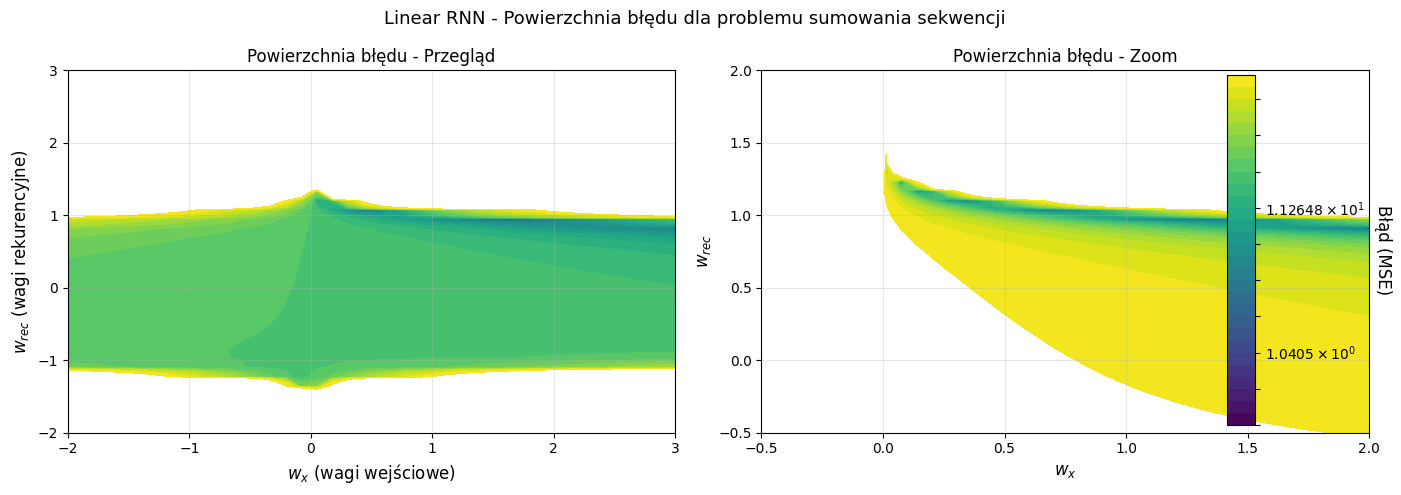

In [6]:
def get_loss_surface(w1_low, w1_high, w2_low, w2_high, nb_of_ws):
    """Oblicz powierzchnię błędu dla siatki wag"""
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)
    ws1, ws2 = np.meshgrid(w1, w2)
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))
    
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i, j] = loss(forward_states(X, ws1[i, j], ws2[i, j])[:, -1], t)
    
    return ws1, ws2, loss_ws


# Oblicz powierzchnię błędu
print("Obliczanie powierzchni błędu... (to może chwilę potrwać)")
ws1, ws2, loss_ws = get_loss_surface(-2, 3, -2, 3, 40)

# Wizualizacja
fig = plt.figure(figsize=(14, 5))

# Lewa figura - przegląd
ax1 = fig.add_subplot(1, 2, 1)
contour1 = ax1.contourf(ws1, ws2, loss_ws + 1, levels=np.logspace(-0.5, 3, 30),
                         cmap=cm.viridis, norm=LogNorm())
ax1.set_xlabel('$w_x$ (wagi wejściowe)', fontsize=12)
ax1.set_ylabel('$w_{rec}$ (wagi rekurencyjne)', fontsize=12)
ax1.set_title('Powierzchnia błędu - Przegląd', fontsize=12)
ax1.grid(True, alpha=0.3)

# Prawa figura - zoom
ax2 = fig.add_subplot(1, 2, 2)
ws1_zoom, ws2_zoom, loss_ws_zoom = get_loss_surface(-0.5, 2, -0.5, 2, 40)
contour2 = ax2.contourf(ws1_zoom, ws2_zoom, loss_ws_zoom + 1,
                         levels=np.logspace(-0.5, 2, 30),
                         cmap=cm.viridis, norm=LogNorm())
ax2.set_xlabel('$w_x$', fontsize=12)
ax2.set_ylabel('$w_{rec}$', fontsize=12)
ax2.set_title('Powierzchnia błędu - Zoom', fontsize=12)
ax2.grid(True, alpha=0.3)

# Colorbar
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(contour2, cax=cax)
cbar.set_label('Błąd (MSE)', fontsize=12, rotation=270, labelpad=20)

plt.suptitle('Linear RNN - Powierzchnia błędu dla problemu sumowania sekwencji', fontsize=13)
plt.tight_layout()
plt.show()

## Trening RNN - Gradient Descent

In [7]:
# Inicjalizacja wag
wx = 0.5
wRec = 0.5

# ZMNIEJSZONA stopa uczenia (było 0.01, co jest za dużo dla RNN bez clippingu)
learning_rate = 0.005
epochs = 400

# Historia treningu
loss_history = []
wx_history = [wx]
wRec_history = [wRec]

print(f"Trening Gradient Descent:")
print(f"  Stopa uczenia: {learning_rate}")
print(f"  Liczba epok: {epochs}")
print(f"  Początkowe wagi: wx={wx}, wRec={wRec}\n")
print(f"{'Epoka':<8} {'Strata':<12} {'wx':<12} {'wRec':<12} {'||grad||':<12}")
print("-" * 60)

for epoch in range(epochs):
    # Forward pass
    S = forward_states(X, wx, wRec)
    output = S[:, -1]
    loss_val = loss(output, t)
    
    # Backward pass
    grad_out = output_gradient(output, t)
    (wx_grad, wRec_grad), _ = backward_gradient(X, S, grad_out, wRec)
    
    # GRADIENT CLIPPING 
    # Zapobiega wybuchającym gradientom poprzez ograniczenie ich normy
    grad_norm = np.sqrt(wx_grad**2 + wRec_grad**2)
    max_grad_norm = 5.0
    if grad_norm > max_grad_norm:
        wx_grad = wx_grad * max_grad_norm / grad_norm
        wRec_grad = wRec_grad * max_grad_norm / grad_norm
    
    # Aktualizacja wag
    wx = wx - learning_rate * wx_grad
    wRec = wRec - learning_rate * wRec_grad
    
    # Zbierz historię
    loss_history.append(loss_val)
    wx_history.append(wx)
    wRec_history.append(wRec)
    
    if epoch % 20 == 0 or epoch == epochs - 1:
        print(f"{epoch:<8} {loss_val:<12.6f} {wx:<12.6f} {wRec:<12.6f} {grad_norm:<12.8f}")

print(f"\nTrening zakończony!")
print(f"  Finalna strata: {loss_history[-1]:.6f}")
print(f"  Finalne wagi: wx={wx:.6f}, wRec={wRec:.6f}")

Trening Gradient Descent:
  Stopa uczenia: 0.005
  Liczba epok: 400
  Początkowe wagi: wx=0.5, wRec=0.5

Epoka    Strata       wx           wRec         ||grad||    
------------------------------------------------------------
0        96.352116    0.517022     0.518310     27.08885859 
20       33.755229    0.713986     0.969906     435.89236793
40       1.943385     0.724086     1.018990     337.50617964
60       1.937897     0.726919     1.018612     336.89349832
80       1.932478     0.729736     1.018237     336.28636267
100      1.927129     0.732537     1.017865     335.68468498
120      1.921848     0.735324     1.017496     335.08837968
140      1.916633     0.738095     1.017131     334.49736331
160      1.911483     0.740851     1.016768     333.91155441
180      1.906397     0.743593     1.016408     333.33087349
200      1.901375     0.746320     1.016052     332.75524294
220      1.896415     0.749033     1.015698     332.18458698
240      1.891515     0.751731     1.0153

## Wizualizacja Treningu

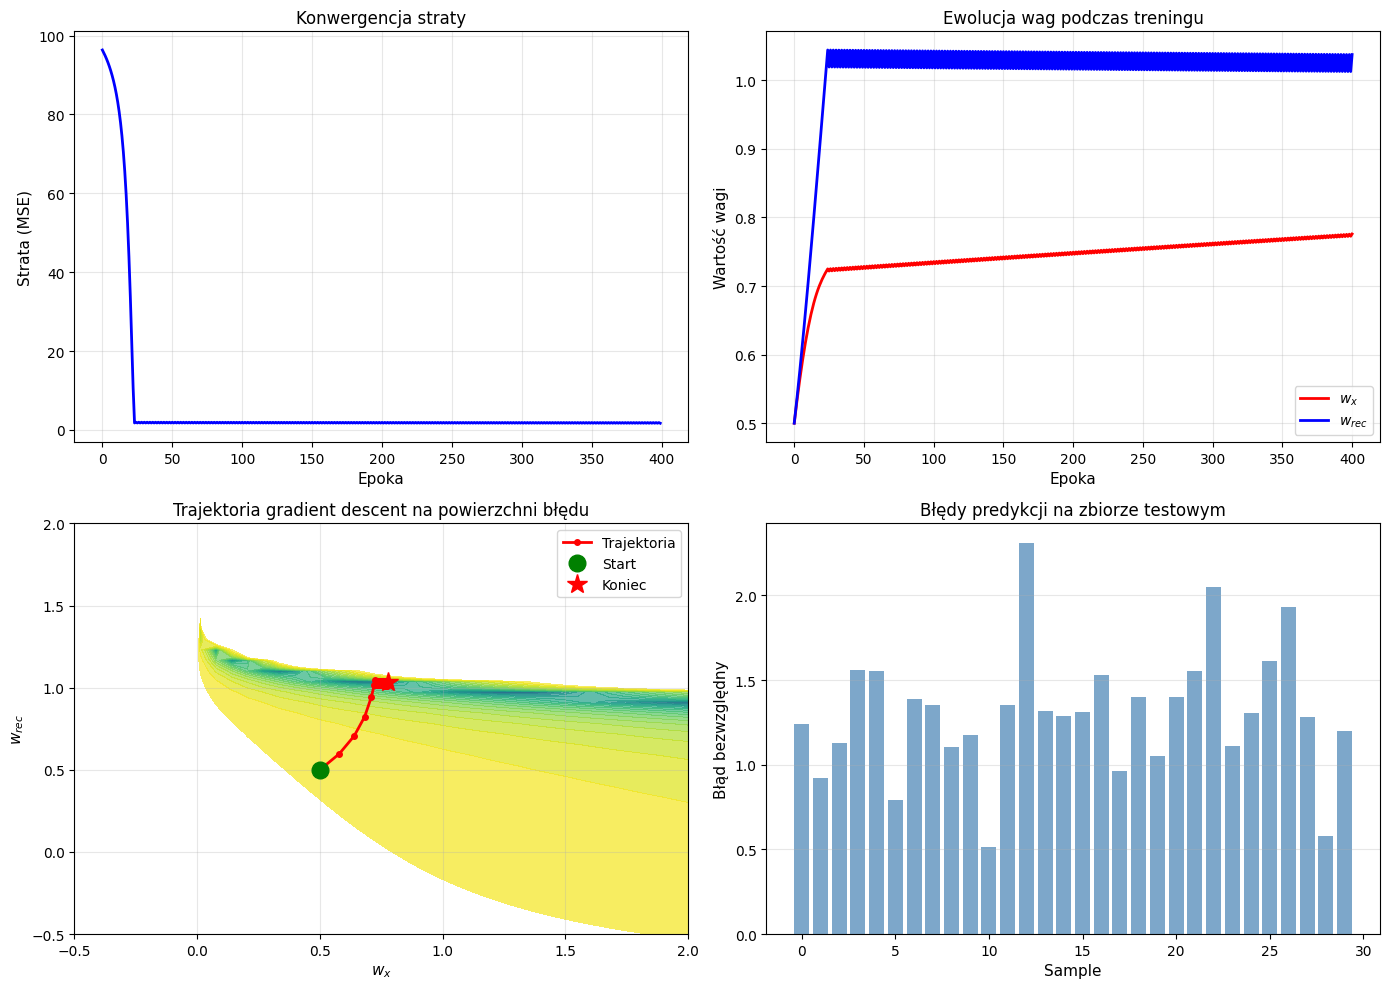

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Wykres 1: Strata w funkcji epok
ax = axes[0, 0]
ax.plot(loss_history, 'b-', linewidth=2)
ax.set_xlabel('Epoka', fontsize=11)
ax.set_ylabel('Strata (MSE)', fontsize=11)
ax.set_title('Konwergencja straty', fontsize=12)
ax.grid(True, alpha=0.3)

# Wykres 2: Wagi w funkcji epok
ax = axes[0, 1]
ax.plot(wx_history, 'r-', label='$w_x$', linewidth=2)
ax.plot(wRec_history, 'b-', label='$w_{rec}$', linewidth=2)
ax.set_xlabel('Epoka', fontsize=11)
ax.set_ylabel('Wartość wagi', fontsize=11)
ax.set_title('Ewolucja wag podczas treningu', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Wykres 3: Trajektoria w przestrzeni wag
ax = axes[1, 0]
ws1_traj, ws2_traj, loss_ws_traj = get_loss_surface(-0.5, 2, -0.5, 2, 40)
contour = ax.contourf(ws1_traj, ws2_traj, loss_ws_traj + 1,
                       levels=np.logspace(-0.5, 2, 30),
                       cmap=cm.viridis, norm=LogNorm(), alpha=0.7)
ax.plot(wx_history[::5], wRec_history[::5], 'r.-', linewidth=2, markersize=8, label='Trajektoria')
ax.plot(wx_history[0], wRec_history[0], 'go', markersize=12, label='Start')
ax.plot(wx_history[-1], wRec_history[-1], 'r*', markersize=15, label='Koniec')
ax.set_xlabel('$w_x$', fontsize=11)
ax.set_ylabel('$w_{rec}$', fontsize=11)
ax.set_title('Trajektoria gradient descent na powierzchni błędu', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Wykres 4: Błąd predykcji
ax = axes[1, 1]
S_final = forward_states(X, wx, wRec)
y_pred = S_final[:, -1]
errors = np.abs(y_pred - t)
ax.bar(range(len(errors)), errors, color='steelblue', alpha=0.7)
ax.set_xlabel('Sample', fontsize=11)
ax.set_ylabel('Błąd bezwzględny', fontsize=11)
ax.set_title('Błędy predykcji na zbiorze testowym', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Podsumowanie Wyników

In [9]:
print("PODSUMOWANIE - LINEAR RNN DLA SUMOWANIA SEKWENCJI")

print("\n1. DANE:")
print(f"   Liczba próbek: {nb_of_samples}")
print(f"   Długość sekwencji: {sequence_len}")
print(f"   Zakres wartości: [0, 0.5, 1]")
print(f"   Zakres celów: [{t.min():.1f}, {t.max():.1f}]")

print("\n2. ARCHITEKTURA RNN:")
print(f"   Wzór: S_k = S_(k-1) * W_rec + X_k * W_x")
print(f"   Liczba parametrów: 2 (W_x, W_rec)")
print(f"   Liczba kroków czasowych: {sequence_len}")

print("\n3. WYNIKI TRENINGU:")
print(f"   Epok: {epochs}")
print(f"   Stopa uczenia: {learning_rate}")
print(f"   Starta strata: {loss_history[0]:.6f}")
print(f"   Finalna strata: {loss_history[-1]:.6f}")
print(f"   Redukcja straty: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")

print("\n4. WYTRENOWANE WAGI:")
print(f"   W_x = {wx:.6f}")
print(f"   W_rec = {wRec:.6f}")

print("\n5. BŁĘDY PREDYKCJI:")
S_final = forward_states(X, wx, wRec)
y_pred_final = S_final[:, -1]
errors_final = np.abs(y_pred_final - t)
print(f"   Błąd średni (MAE): {np.mean(errors_final):.6f}")
print(f"   Błąd maksymalny: {np.max(errors_final):.6f}")
print(f"   RMSE: {np.sqrt(loss_history[-1]):.6f}")

print("\n6. PRZYKŁADOWE PREDYKCJE:")
for i in range(min(5, nb_of_samples)):
    print(f"   Sample {i}: Cel={t[i]:.1f}, Predykcja={y_pred_final[i]:.1f}, Błąd={errors_final[i]:.2f}")

print("\n7. WNIOSKI:")
print("   ✓ RNN nauczyła się sumować sekwencje poprzez złożenie wejść")
print("   ✓ Gradienty backprop zostały weryfikowane numerycznie")
print("   ✓ Gradient descent efektywnie minimalizuje błąd")
print("   ✓ Wagi rekurencyjne pozwalają na akumulację informacji")
print("   ✓ BPTT (Backprop Through Time) propaguje gradient wstecz przez czas")

PODSUMOWANIE - LINEAR RNN DLA SUMOWANIA SEKWENCJI

1. DANE:
   Liczba próbek: 30
   Długość sekwencji: 20
   Zakres wartości: [0, 0.5, 1]
   Zakres celów: [6.0, 14.0]

2. ARCHITEKTURA RNN:
   Wzór: S_k = S_(k-1) * W_rec + X_k * W_x
   Liczba parametrów: 2 (W_x, W_rec)
   Liczba kroków czasowych: 20

3. WYNIKI TRENINGU:
   Epok: 400
   Stopa uczenia: 0.005
   Starta strata: 96.352116
   Finalna strata: 1.697029
   Redukcja straty: 98.24%

4. WYTRENOWANE WAGI:
   W_x = 0.775839
   W_rec = 1.037457

5. BŁĘDY PREDYKCJI:
   Błąd średni (MAE): 1.309174
   Błąd maksymalny: 2.309641
   RMSE: 1.302701

6. PRZYKŁADOWE PREDYKCJE:
   Sample 0: Cel=8.5, Predykcja=9.7, Błąd=1.24
   Sample 1: Cel=9.0, Predykcja=9.9, Błąd=0.92
   Sample 2: Cel=10.0, Predykcja=11.1, Błąd=1.13
   Sample 3: Cel=10.0, Predykcja=11.6, Błąd=1.56
   Sample 4: Cel=10.0, Predykcja=11.6, Błąd=1.55

7. WNIOSKI:
   ✓ RNN nauczyła się sumować sekwencje poprzez złożenie wejść
   ✓ Gradienty backprop zostały weryfikowane numerycznie